# Packages

In [127]:
import warnings # Serve para ignorar mensagens de alerta que aparecem 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import pickle
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

from tqdm import tqdm

from pycaret.regression import *

In [129]:
from utils.model_summary_functions import feature_importance, metrics, summary_plot,multivariate_importance

In [130]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 16,
    'axes.linewidth': 2,
    'axes.titlesize': 20,
    'axes.edgecolor': 'black',
    'axes.labelsize': 20,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': 'Arial',
    'legend.fontsize': 13,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
    'text.color': 'black',
    'axes.labelcolor': 'black',
})


# Importing the dataset

In [131]:
df = pd.read_csv('dataframe_time_series/df_eigenvector_0.csv', index_col=[0])

In [132]:
df

,value__sum_values,value__time_reversal_asymmetry_statistic__lag_1,0
1,5.472871,0.000000,4.998962
2,10.929607,0.000000,4.715525
3,16.386504,-0.952703,4.381708
4,21.859133,-0.002444,4.001168
5,21.887872,1.814690,3.578221
...,...,...,...
5982,-35.006891,10.210536,-4.149586
5983,-34.791830,20.770420,-3.869611
5984,-34.416726,33.823266,-3.593313
5985,-33.847343,47.974401,-3.312633


In [133]:
df_train = df[:5400]
df_test = df[5400:]

In [134]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 586 entries, 5401 to 5986
Data columns (total 3 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   value__sum_values                                586 non-null    float64
 1   value__time_reversal_asymmetry_statistic__lag_1  586 non-null    float64
 2   0                                                586 non-null    float64
dtypes: float64(3)
memory usage: 18.3 KB


# Testing Pycaret

In [135]:
# Initialize Pycaret
#s = setup(data = df_train,
#              test_data = df_test.astype('float'), 
#              target=df_train.columns[-1],
#              data_split_shuffle = False,
#              use_gpu = True,
#              fold_strategy = 'timeseries',
#              preprocess = False,
#              fold = 3,
#              silent=True,
#              session_id = 123,
#              verbose=False) # testing for predicting one time series


In [136]:
# Training all models from the above list with the exception of three and get the best 3

#exclude=['lar','par','dt','knn','llar','lasso','en','xgboost','omp','rf'],

#best_model = compare_models(sort = 'MAE',
#                            exclude=['lightgbm', 'lar', 'llar', 'par','omp','en','knn','xgboost','ridge','br','lasso','lr','dt','huber'],
#                            round = 3,
#                            n_select = 3)

In [137]:
#best_model[0]

In [138]:
# Hyperparameter tuning with optuna 

#best_model_tuned = tune_model(best_model[0], 
#                                      n_iter = 4,
#                                      search_library='optuna',
#                                      #search_algorithm='tpe',
#                                      optimize = 'RMSE',
#                                      verbose=True,
#                                      choose_better=True)

In [139]:
#best_model_tuned

## Visualizing prediction

In [140]:
# generate predictions for the entire dataset
#predictions = predict_model(best_model_tuned)
#predictions['time_step'] = predictions.index - predictions.index.min() + 1
#predictions

In [141]:
# Plotting the entire dataset
#plt.figure(figsize=(12,5))
#plt.plot(predictions['Label'],color='blue',label='Predicted value')
#plt.plot(predictions[df.columns[-1]],color='red',alpha=0.7,label='Real value')
#plt.xlabel('Time steps')
#plt.ylabel('Series')
#plt.legend()

# add a vertical rectange for test-set separation
#plt.axvspan(xmin=predictions.index[0], xmax=predictions.index[-1], color='grey', alpha=0.4)

In [142]:
#metrics(predictions['Label'],predictions[df.columns[-1]])

# Training all time series

In [143]:
#from joblib import Parallel, delayed

In [144]:
all_results = [] 
final_model = {}

def train_all_time_series(eigenvector):
    
    i = eigenvector
    
    # Import the dataset of a specific eigenvector to forecast
    path = 'dataframe_time_series/df_eigenvector_{}.csv'.format(i)
    df = pd.read_csv(path, index_col=[0])
    df_train = df[:5400]
    df_test = df[5400:]    
        
    # Initialize Pycaret
    s = setup(data=df_train,
               test_data=df_test,
               target=df_train.columns[-1],
               data_split_shuffle=False,
               use_gpu=True,
               fold_strategy='timeseries',
               preprocess=False,
               fold=5,
               silent=True,
               session_id=123,
               verbose=False)
    
    print('Setup complete')
        
    # Test and compare different ML models and choose the best
    best_model = compare_models(sort = 'RMSE',
                                    exclude=['lightgbm', 'lar', 'llar', 'par','omp','en','knn','xgboost','ridge','br','lr','dt','huber'],
                                    n_select = 1,
                                    verbose=False) 
    
    print('Hyperparameter optimization has begun')

    # Hyperparameter tuning with optuna 
    best_model_tuned = tune_model(best_model, 
                                      n_iter = 70,
                                      search_library='optuna',
                                      #search_algorithm='tpe',
                                      optimize = 'RMSE',
                                      verbose=False,
                                      choose_better=True)
    
    best_model_tuned=best_model
    
    print('Hyperparameter optimization complete')

    # Capture the result grid and store best model in list
    p = pull().iloc[0:1]
    p['time_series'] = str(i)
    all_results.append(p)
    
    # Save the model
    f = finalize_model(best_model_tuned) # finalize model i.e fit on entire dataset including test set
    final_model[i] = f # Attach final model to a dictionary
    save_model(f, model_name='trained_models/' + str(i), verbose=False) # pickle the trained model into this folder
    
    print('Model saved')    
    
    return  

In [145]:
#Parallel(n_jobs=6)(train_all_time_series(eigenvector) for eigenvector in np.arange(0,93,1))  
#12
eigenvectors = np.arange(0, 93, 1)

for i in tqdm(eigenvectors):
    train_all_time_series(i)

  0%|          | 0/93 [00:00<?, ?it/s]

Setup complete


In [ ]:
#all_results = [] # Save the MAE result for each HORIZON value to determine how far we can forecast
#final_model = {}

#eigenvectors = np.arange(0,20,1)

#for i in tqdm(eigenvectors):
    
    # Import the dataset of a specific eigenvector to forecast
#    path = 'dataframe_time_series/df_eigenvector_{}.csv'.format(i)
#    df = pd.read_csv(path, index_col=[0])
#    df_train = df[:5400]
#    df_test = df[5400:]    
        
    # Initialize Pycaret
#    s = setup(data=df_train,
#               test_data=df_test,
#               target=df_train.columns[-1],
#               data_split_shuffle=False,
#               use_gpu=True,
#               fold_strategy='timeseries',
#               preprocess=False,
#               fold=5,
#               silent=True,
#               session_id=123,
#               verbose=False)
    
#    print('Setup complete')
        
    # Test and compare different ML models and choose the best
#    best_model = compare_models(sort = 'RMSE',
#                                    exclude=['lightgbm', 'lar', 'llar', 'par','omp','en','knn','xgboost','ridge','br','lasso','lr','dt','huber'],
#                                    n_select = 1,
#                                    verbose=False) 
    
#    print('Hyperparameter optimization has begun')

    # Hyperparameter tuning with optuna 
#    best_model_tuned = tune_model(best_model, 
#                                      n_iter = 150,
#                                      search_library='optuna',
                                      #search_algorithm='tpe',
#                                      optimize = 'RMSE',
#                                      verbose=False,
#                                      choose_better=True)
    
#    best_model_tuned=best_model
    
#    print('Hyperparameter optimization complete')

    # Capture the result grid and store best model in list
##    p = pull().iloc[0:1]
#    p['time_series'] = str(i)
#    all_results.append(p)
    
    # Save the model
#    f = finalize_model(best_model_tuned) # finalize model i.e fit on entire dataset including test set
#    final_model[i] = f # Attach final model to a dictionary
#    save_model(f, model_name='trained_models/' + str(i), verbose=False) # pickle the trained model into this folder
    
#    print('Model saved')
    
# Source: https://towardsdatascience.com/multiple-time-series-forecasting-with-pycaret-bc0a779a22fe 


In [ ]:
# Display the best model results for each time series.

concat_results = pd.concat(all_results,axis=0)
concat_results.reset_index(inplace=True,drop=True)
concat_results.head(10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,time_series
0,1.7647,4.6232,2.1502,0.8176,0.5255,1.8195,0
1,2.0555,6.2211,2.4942,0.7301,0.5488,4.6647,1
2,1.6182,3.8694,1.9671,0.7628,0.4959,1.6789,2
3,1.7737,5.4545,2.3355,0.7674,0.4818,1.1565,3
4,1.6543,4.4190,2.1021,0.8104,0.4626,1.6057,4
5,2.2778,10.1289,3.1826,0.5907,0.6721,1.6912,5
6,1.7248,4.4932,2.1197,0.7081,0.5252,1.6135,6
7,1.4568,3.3454,1.8290,0.8074,0.4561,2.4723,7
8,1.5762,4.0592,2.0148,0.7570,0.5129,2.2262,8
9,1.4934,3.7349,1.9326,0.6817,0.4832,1.5257,9


In [ ]:
concat_results.tail(10)


,MAE,MSE,RMSE,R2,RMSLE,MAPE,time_series
83,0.5872,0.5371,0.7328,0.3169,0.3651,2.6364,83
84,0.4472,0.3162,0.5623,0.3098,0.2892,1.7002,84
85,0.4655,0.3430,0.5857,0.2806,0.2961,2.7337,85
86,0.5512,0.4664,0.6829,0.1011,0.3321,6.8406,86
87,0.4427,0.2957,0.5437,0.2693,0.2864,4.9712,87
88,0.4181,0.2747,0.5241,0.3855,0.2804,5.7919,88
89,0.4489,0.3456,0.5878,0.2991,0.2984,2.4275,89
90,0.4633,0.3456,0.5879,0.1961,0.2995,4.3604,90
91,0.4262,0.2736,0.5231,0.2504,0.2862,1.6903,91
92,0.4482,0.3053,0.5525,0.1314,0.3126,8.8366,92


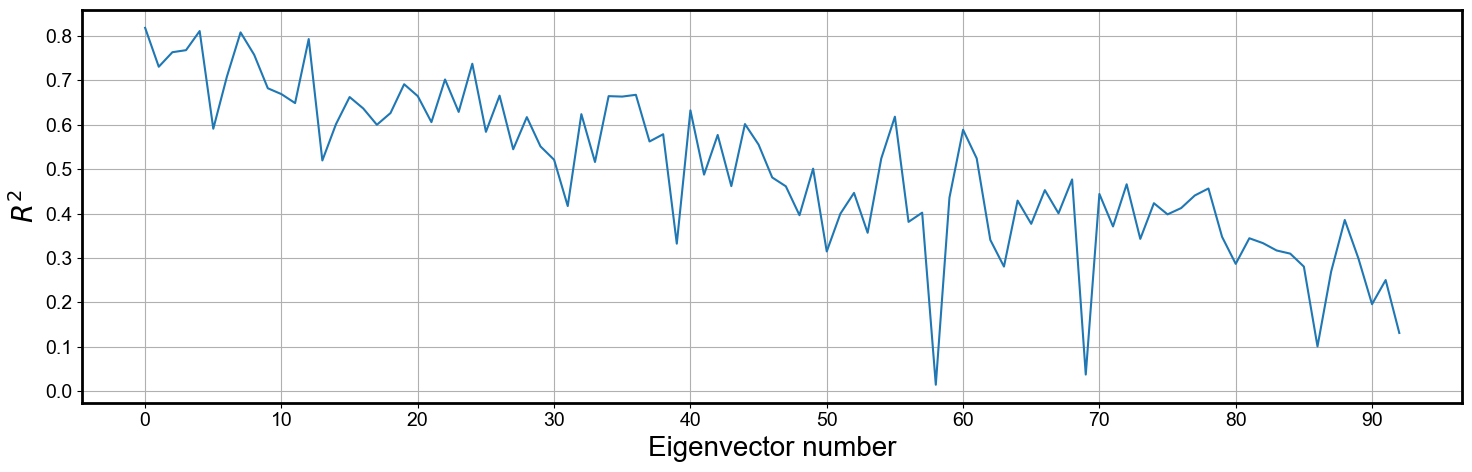

In [ ]:
ax, fig = plt.subplots(1,1,figsize=(15,5))

plt.plot(concat_results['time_series'],concat_results['R2'])

plt.ylabel('$R^2$')
plt.xlabel('Eigenvector number')
plt.xticks([0, 10, 20,30,40,50,60,70,80,90])
#plt.title('Forecasting MAE for each time series')

plt.tight_layout()


## Loading trained models

In [ ]:
# Now let’s create a loop to load the trained pipelines and use the predict_model function to generate prediction labels.

all_score_df = []
eigenvectors = np.arange(0, 93, 1)

for i in tqdm(eigenvectors):
    l = load_model('trained_models/' + str(i), verbose=False)

    # Import the dataset of a specific eigenvector to forecast
    path = 'dataframe_time_series/df_eigenvector_{}.csv'.format(i)
    dataframe = pd.read_csv(path, index_col=[0])
    dataframe_train = dataframe[:5400]
    dataframe_test = dataframe[5400:] 

    p = predict_model(l, data=dataframe_test)
    all_score_df.append(p)

concat_df = pd.concat(all_score_df, axis=1)
print(concat_df.shape)
concat_df.head(10)

100%|██████████| 93/93 [00:19<00:00,  4.75it/s]

(586, 489)


,value__sum_values,value__time_reversal_asymmetry_statistic__lag_1,0,Label,value__sum_values,value__time_reversal_asymmetry_statistic__lag_1,value__c3__lag_1,value__energy_ratio_by_chunks__num_segments_10__segment_focus_1,0,Label,...,Label,value__sum_values,value__mean_second_derivative_central,"value__fft_coefficient__attr_""angle""__coeff_1",0,Label,value__sum_values,"value__fft_coefficient__attr_""angle""__coeff_1",0,Label
5401,31.304532,-26.719237,5.621250,4.363081,-2.157706,-0.455265,-0.137100,0.069889,-5.399308,-4.118190,...,0.261152,-1.119207,0.006753,-36.283841,-0.353770,-0.165052,-0.007614,-47.608864,0.346541,-0.508229
5402,30.855540,-27.413607,5.435500,4.363081,-3.607943,-1.261556,-0.694686,0.126557,-5.412251,-4.492097,...,0.433258,-1.267933,0.006865,-32.285547,-0.400982,-0.079330,-0.203811,-44.991550,0.462017,-0.456623
5403,30.381224,-28.101080,5.233554,4.836750,-5.128651,-2.619794,-2.044961,0.158691,-5.386979,-4.894635,...,0.620306,-1.362493,0.006789,-22.966266,-0.446773,-0.108758,-0.400835,-42.641069,0.555214,-0.189795
5404,29.880301,-28.715772,5.018999,4.591573,-6.712262,-4.618830,-4.637778,0.178623,-5.331192,-5.536991,...,0.620306,-1.404209,0.006345,15.158006,-0.488274,-0.040412,-0.583336,-40.249451,0.619014,0.044822
5405,29.352697,-29.158456,4.797539,4.732049,-8.344270,-7.285858,-8.970919,0.192333,-5.252566,-5.922907,...,0.433258,-1.397135,0.005409,101.312543,-0.524192,-0.058230,-0.738888,-37.394893,0.652106,0.063132
5406,28.800146,-29.323395,4.575244,5.270392,-10.003552,-10.546198,-15.528924,0.202585,-5.158087,-5.931317,...,0.361944,-1.348838,0.003960,122.236896,-0.554865,-0.030690,-0.858498,-32.983961,0.657873,0.200443
5407,28.226431,-29.124906,4.357185,5.355587,-11.663051,-14.191800,-24.693794,0.210757,-5.053669,-6.495928,...,0.301268,-1.270473,0.002108,129.884189,-0.582070,0.129673,-0.936040,-22.500522,0.642215,0.207614
5408,27.637216,-28.519373,4.146789,4.599527,-13.290893,-17.872438,-36.639156,0.217588,-4.944061,-6.837244,...,0.238024,-1.176040,0.000057,134.873298,-0.608663,-0.092590,-0.966766,28.545489,0.611487,0.249812
5409,27.039419,-27.520695,3.945790,3.481000,-14.852003,-21.122243,-51.229951,0.223493,-4.832906,-5.832280,...,0.176014,-1.081041,-0.001967,139.723297,-0.638072,-0.191192,-0.945430,103.314483,0.571087,0.281770
5410,26.440077,-26.210039,3.754543,3.502535,-16.310210,-23.427361,-67.957277,0.228708,-4.722781,-6.466420,...,0.238024,-1.000900,-0.003771,146.790221,-0.673568,-0.407311,-0.864874,117.802803,0.524659,0.304368


100%|██████████| 5/5 [00:01<00:00,  4.53it/s]


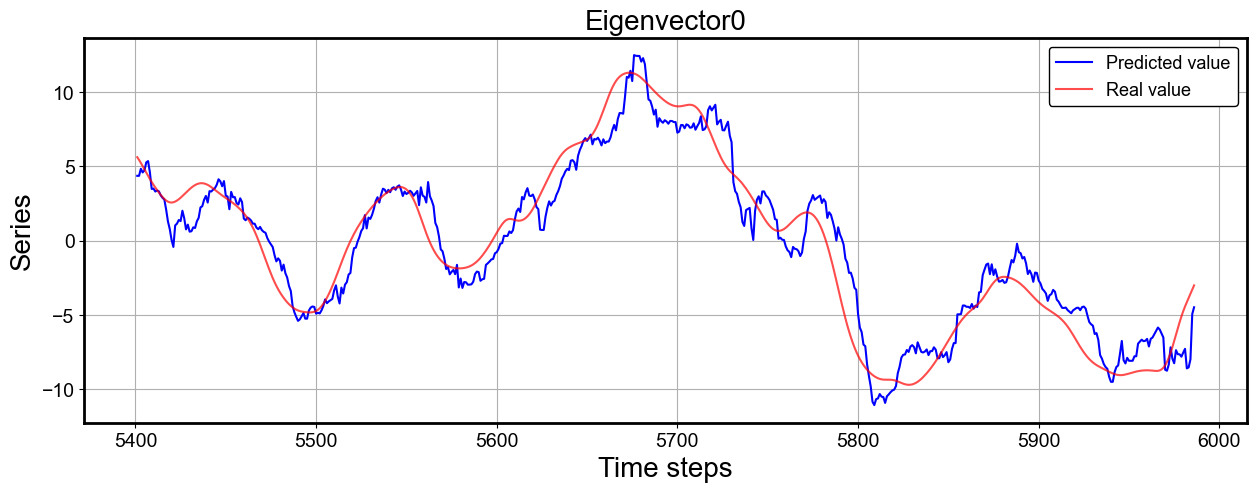

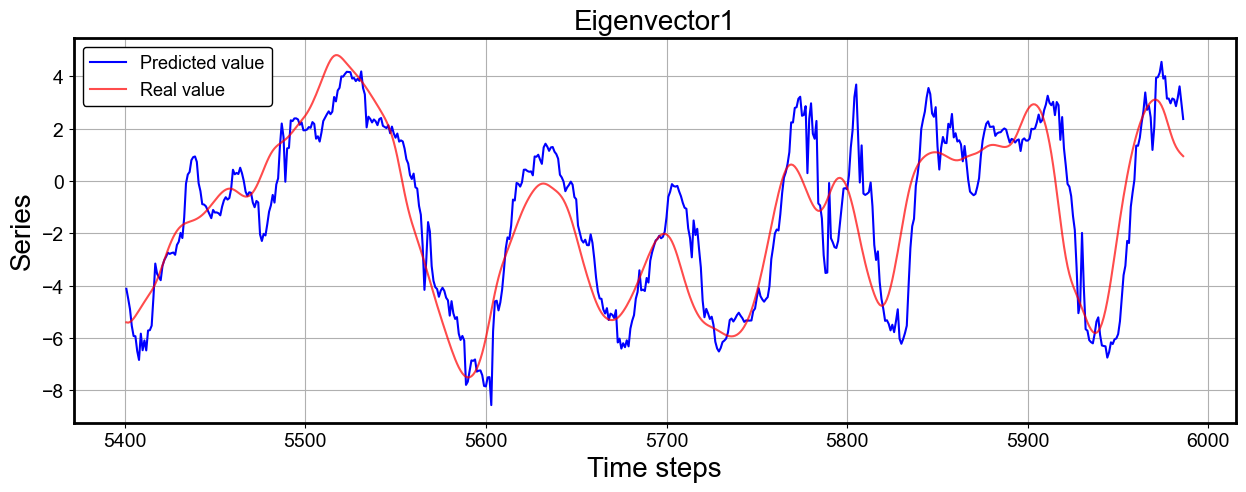

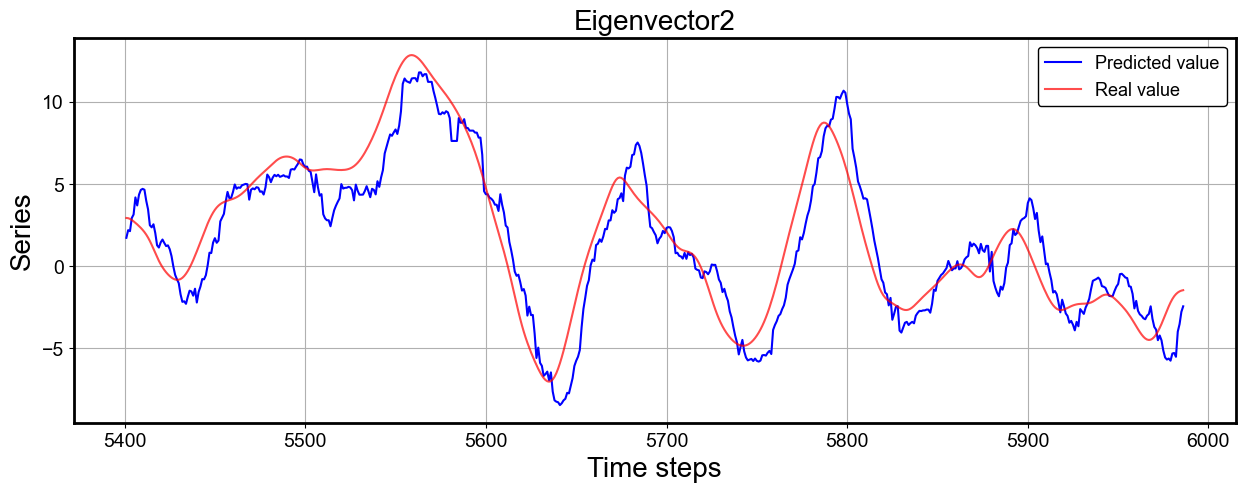

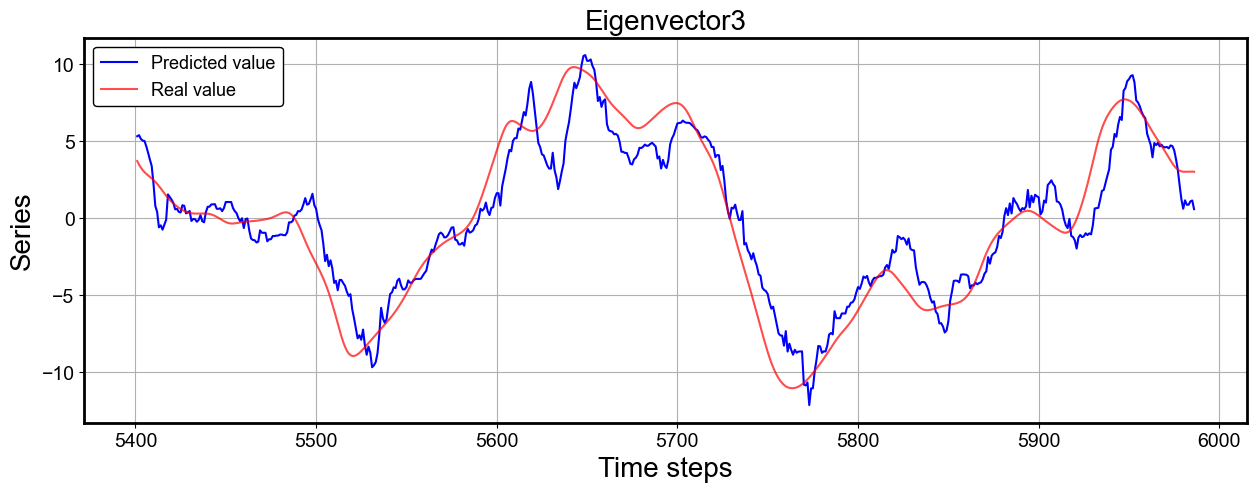

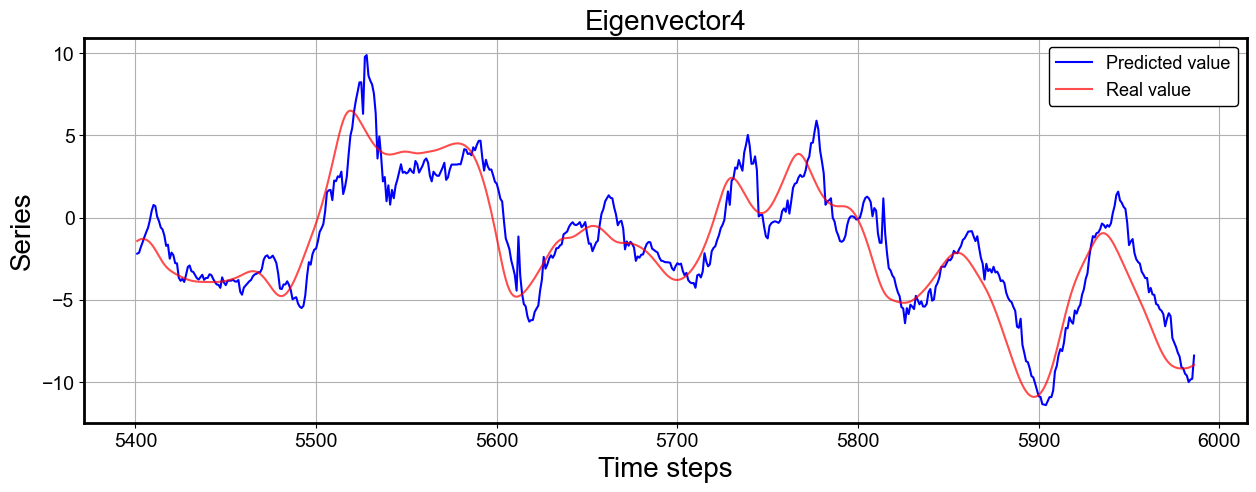

In [ ]:
# Plot comparison for test dataset - first eigenvectors

for i in tqdm(range(5)):
    
    # Import the dataset of a specific eigenvector to forecast
    path = 'dataframe_time_series/df_eigenvector_{}.csv'.format(i)
    dataframe = pd.read_csv(path, index_col=[0])
    dataframe_train = dataframe[:5400]
    dataframe_test = dataframe[5400:]   
    
    l = load_model('trained_models/' + str(i), verbose=False)
    p = predict_model(l, data=dataframe_test)
    
    # Plotting
    plt.figure(figsize=(15,5))
    
    plt.plot(p['Label'],color='blue',label='Predicted value')
    plt.plot(p[dataframe.columns[-1]],color='red',alpha=0.7,label='Real value')
    
    plt.title('Eigenvector' + str(i))
    plt.xlabel('Time steps')
    plt.ylabel('Series')
    plt.legend()


In [ ]:
concat_results['R2']

0     0.8176
1     0.7301
2     0.7628
3     0.7674
4     0.8104
       ...  
88    0.3855
89    0.2991
90    0.1961
91    0.2504
92    0.1314
Name: R2, Length: 93, dtype: float64

In [ ]:
concat_df # All datasets are concatenated horizontally. We want only the forecast column and the label column

,value__sum_values,value__time_reversal_asymmetry_statistic__lag_1,0,Label,value__sum_values,value__time_reversal_asymmetry_statistic__lag_1,value__c3__lag_1,value__energy_ratio_by_chunks__num_segments_10__segment_focus_1,0,Label,...,Label,value__sum_values,value__mean_second_derivative_central,"value__fft_coefficient__attr_""angle""__coeff_1",0,Label,value__sum_values,"value__fft_coefficient__attr_""angle""__coeff_1",0,Label
5401,31.304532,-26.719237,5.621250,4.363081,-2.157706,-0.455265,-0.137100,0.069889,-5.399308,-4.118190,...,0.261152,-1.119207,0.006753,-36.283841,-0.353770,-0.165052,-0.007614,-47.608864,0.346541,-0.508229
5402,30.855540,-27.413607,5.435500,4.363081,-3.607943,-1.261556,-0.694686,0.126557,-5.412251,-4.492097,...,0.433258,-1.267933,0.006865,-32.285547,-0.400982,-0.079330,-0.203811,-44.991550,0.462017,-0.456623
5403,30.381224,-28.101080,5.233554,4.836750,-5.128651,-2.619794,-2.044961,0.158691,-5.386979,-4.894635,...,0.620306,-1.362493,0.006789,-22.966266,-0.446773,-0.108758,-0.400835,-42.641069,0.555214,-0.189795
5404,29.880301,-28.715772,5.018999,4.591573,-6.712262,-4.618830,-4.637778,0.178623,-5.331192,-5.536991,...,0.620306,-1.404209,0.006345,15.158006,-0.488274,-0.040412,-0.583336,-40.249451,0.619014,0.044822
5405,29.352697,-29.158456,4.797539,4.732049,-8.344270,-7.285858,-8.970919,0.192333,-5.252566,-5.922907,...,0.433258,-1.397135,0.005409,101.312543,-0.524192,-0.058230,-0.738888,-37.394893,0.652106,0.063132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5982,-35.006891,10.210536,-4.149586,-8.613717,11.464017,3.571047,23.621275,0.241997,1.311779,2.864881,...,0.238024,4.632925,0.001553,133.760359,-0.227933,0.774541,0.695860,146.183837,0.457089,-0.221432
5983,-34.791830,20.770420,-3.869611,-8.550930,11.851292,3.020660,26.106507,0.244452,1.194403,3.190598,...,0.176014,4.912180,-0.001969,136.580456,-0.337113,0.650919,0.883736,148.944527,0.505647,-0.080534
5984,-34.416726,33.823266,-3.593313,-8.008749,12.141875,2.241605,28.088728,0.247000,1.100201,3.620749,...,0.169312,5.175904,-0.005436,139.857796,-0.390954,0.484437,1.003456,150.909842,0.545995,-0.113625
5985,-33.847343,47.974401,-3.312633,-4.951921,12.324156,1.222969,29.390836,0.249740,1.021631,3.010058,...,0.169312,5.397480,-0.008568,144.731810,-0.395280,0.442638,1.074937,149.808537,0.572288,-0.113625


In [ ]:
predicted_time_series = concat_df.loc[:,concat_df.columns == 'Label']
ground_truth = concat_df.loc[:,concat_df.columns == '0']

In [ ]:
predicted_time_series.columns = ['Forecast' + str(i) for i in range(len(eigenvectors))]
ground_truth.columns = ['Ground_truth' + str(i) for i in range(len(eigenvectors))]
predicted_time_series

,Forecast0,Forecast1,Forecast2,Forecast3,Forecast4,Forecast5,Forecast6,Forecast7,Forecast8,Forecast9,...,Forecast83,Forecast84,Forecast85,Forecast86,Forecast87,Forecast88,Forecast89,Forecast90,Forecast91,Forecast92
5401,4.363081,-4.118190,1.697593,5.300872,-2.199877,-5.522640,-0.244726,3.978671,-6.743042,-3.168365,...,-0.654232,0.027905,-0.555645,-0.025845,-0.072794,0.009073,0.193278,0.261152,-0.165052,-0.508229
5402,4.363081,-4.492097,2.167632,5.370715,-2.146623,-5.798625,0.026388,4.125737,-6.418615,-3.010055,...,-1.152356,0.285247,-0.485742,-0.005572,-0.018744,0.174483,0.367220,0.433258,-0.079330,-0.456623
5403,4.836750,-4.894635,2.104606,5.129378,-1.796159,-5.549005,0.948054,4.109815,-6.573006,-3.228553,...,-1.097049,0.319983,-0.516146,0.113007,0.066831,0.271369,0.255533,0.620306,-0.108758,-0.189795
5404,4.591573,-5.536991,2.908433,5.020334,-1.498702,-6.053267,1.020551,4.865650,-6.432472,-3.134957,...,-1.119430,0.307633,-0.620020,0.244130,-0.039894,0.303003,0.221888,0.620306,-0.040412,0.044822
5405,4.732049,-5.922907,3.119174,4.992024,-1.177393,-5.823845,1.957183,5.045536,-5.581602,-3.023991,...,-0.792249,0.348422,-0.523267,0.436412,-0.034862,0.367468,0.102133,0.433258,-0.058230,0.063132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5982,-8.613717,2.864881,-5.552447,0.845277,-9.631846,2.061174,-2.349449,4.800210,0.823073,-3.192351,...,-0.178286,-0.612973,-0.029003,0.188487,0.839266,0.009073,0.682681,0.238024,0.774541,-0.221432
5983,-8.550930,3.190598,-4.019737,0.853557,-10.025261,1.992909,-1.246206,5.038542,0.699497,-3.930180,...,-0.114545,-0.641990,-0.120790,0.253853,0.793564,0.009073,0.486869,0.176014,0.650919,-0.080534
5984,-8.008749,3.620749,-3.561309,1.072892,-9.868745,1.924208,0.504557,5.147194,1.403356,-3.924109,...,-0.098422,-0.596877,0.194398,0.004167,0.758904,0.094600,0.311764,0.169312,0.484437,-0.113625
5985,-4.951921,3.010058,-2.813779,1.126317,-9.822173,2.043247,-0.652573,4.616116,1.719233,-3.996846,...,0.106442,-0.459118,0.199936,-0.365856,0.523446,0.151393,0.077833,0.169312,0.442638,-0.113625


In [ ]:
#MAE = pd.DataFrame(abs(ground_truth.to_numpy()-predicted_time_series.to_numpy()),index=ground_truth.index)
#sns.heatmap(MAE,cmap='seismic')
#print('MAE metric: ',MAE.mean().mean())

Mean absolute error (MAE) for forecasting: 0.8431201086124468


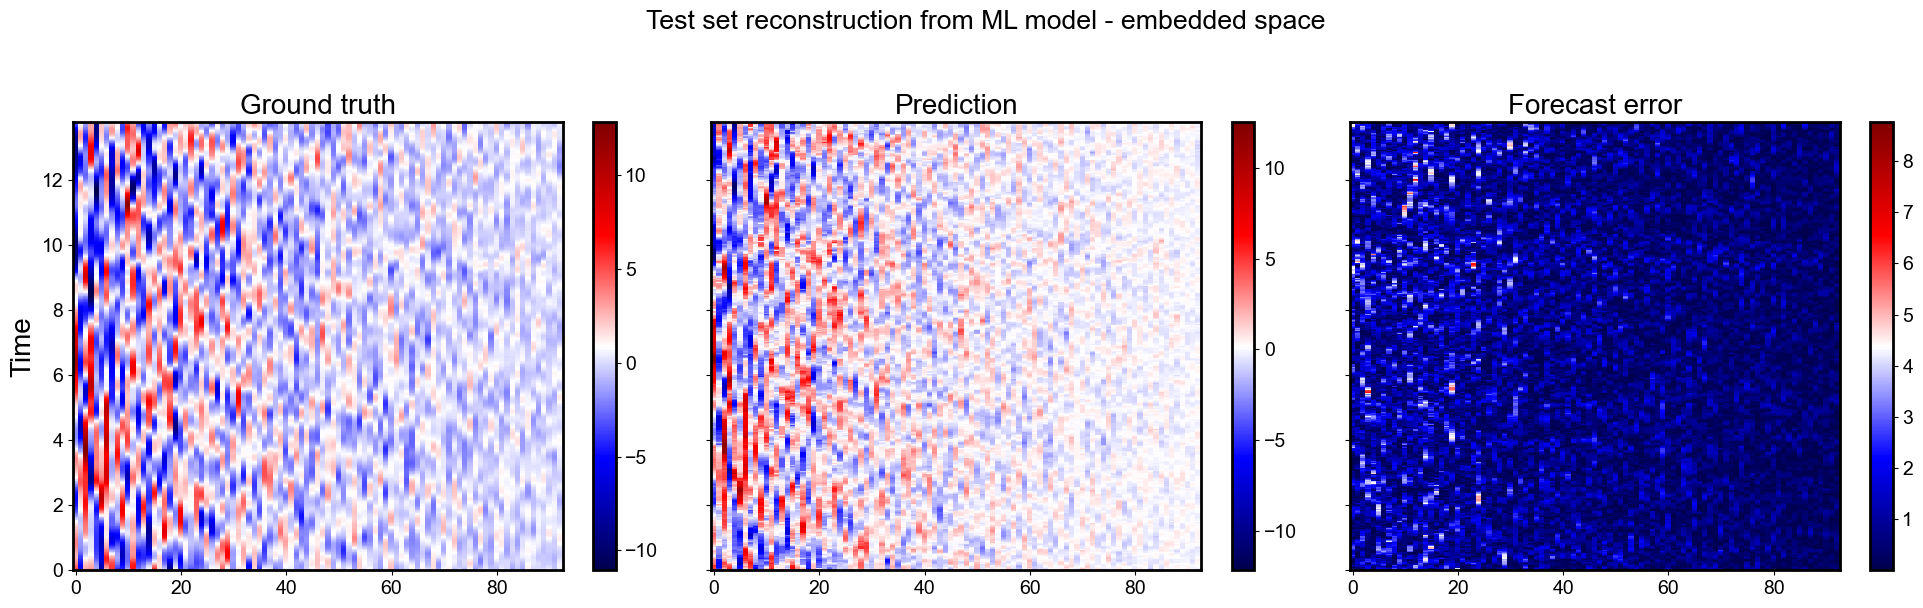

In [ ]:
fig, ax = plt.subplots(1,3,sharey=True,figsize=(20, 6))
plt.suptitle('Test set reconstruction from ML model - embedded space', y=1.02)

a, b = np.meshgrid(eigenvectors,ground_truth.index.values)
MLE = 0.094
dt = 0.25

surf1 = ax[0].pcolor(a, (b-5401)*dt*MLE, ground_truth, cmap=plt.get_cmap("seismic"),shading='auto')
ax[0].set_title('Ground truth')
ax[0].set_ylabel('Time')

surf2 = ax[1].pcolor(a, (b-5401)*dt*MLE, predicted_time_series,cmap=plt.get_cmap("seismic"),shading='auto')
ax[1].set_title('Prediction')

diff = abs(ground_truth.to_numpy()-predicted_time_series.to_numpy())
surf3 = ax[2].pcolor(a,  (b-5401)*dt*MLE, diff,cmap=plt.get_cmap("seismic"),shading='auto')
ax[2].set_title('Forecast error')

plt.colorbar(surf1, ax=ax[0])
plt.colorbar(surf2, ax=ax[1])
plt.colorbar(surf3, ax=ax[2])

plt.tight_layout()
print('Mean absolute error (MAE) for forecasting: {}'.format(np.mean(diff.mean())))

# Visualizing the Kuramoto equation from model prediction

In [ ]:
path = 'pca_models/pca_Kuramoto'
pca = pickle.load(open(path, 'rb'))

In [ ]:
pca.model_red

PCA(copy=True, iterated_power='auto', n_components=93, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
# Returning the 93 time series back into the problem series
y_test_forecast = pd.DataFrame(pca.model_red.inverse_transform(predicted_time_series),index=ground_truth.index) 
y_test_truth = pd.DataFrame(pca.model_red.inverse_transform(ground_truth),index=ground_truth.index) 

In [ ]:
path = 'pca_models/standardscaler'
std_scaler = pickle.load(open(path, 'rb'))

U_forecast_inverse = pd.DataFrame(std_scaler.inverse_transform(y_test_forecast),index=ground_truth.index)
U_truth_inverse = pd.DataFrame(std_scaler.inverse_transform(y_test_truth),index=ground_truth.index)

In [ ]:
X = np.linspace(0,200,512) # Discrete space domain vector
T = np.load('Kuramoto_dataset\KSTime.npy') # Discrete time domain vector
U = np.load('Kuramoto_dataset\KSSolution.npy') # Solution
X, T = np.meshgrid(X, T)

X_test2 = X[U_forecast_inverse.index]
T_test2 = T[U_forecast_inverse.index]
U_test2 = U[U_forecast_inverse.index]

Mean absolute error (MAE) for forecasting: 0.4730538956153979


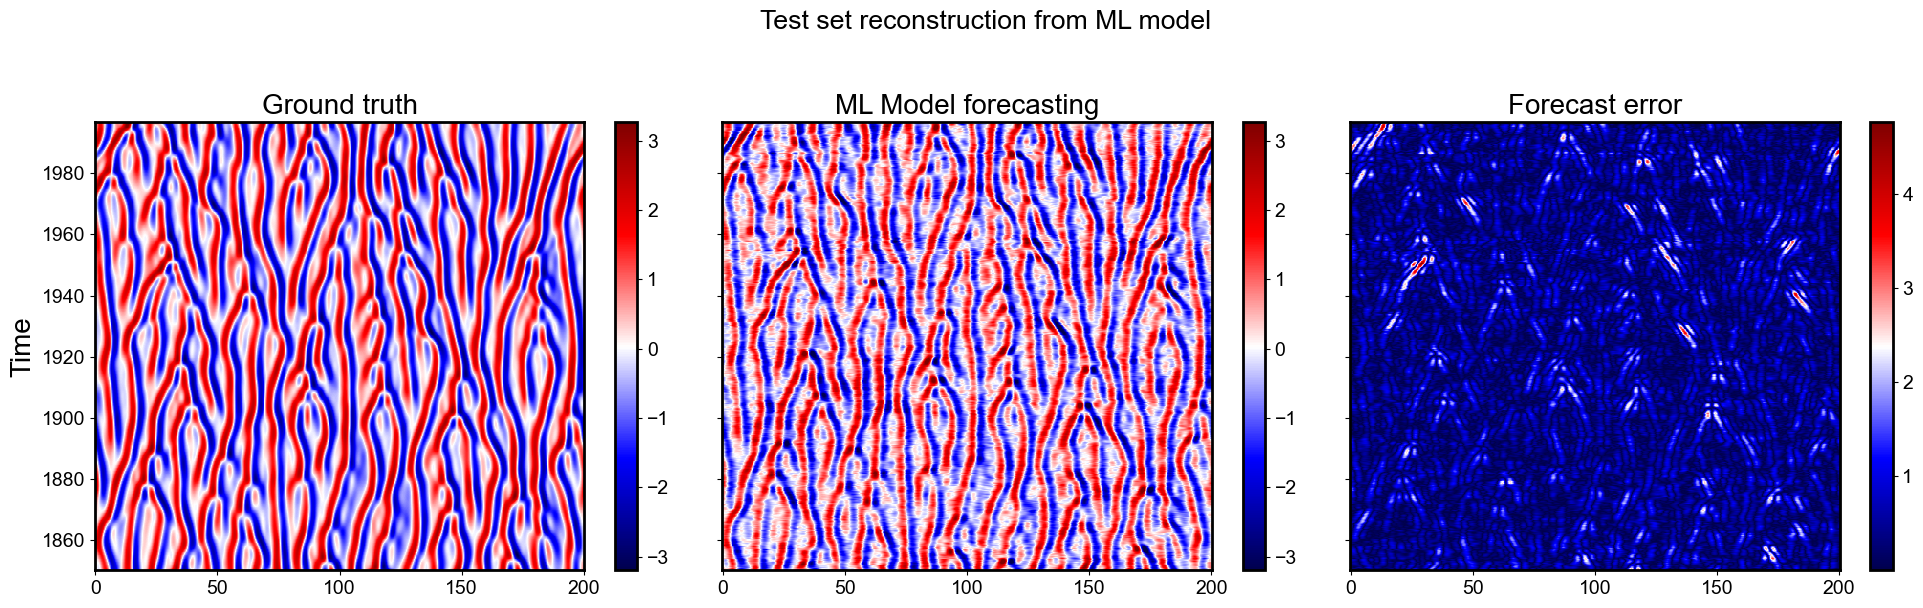

In [ ]:
fig, ax = plt.subplots(1,3,sharey=True,figsize=(20, 6))
plt.suptitle('Test set reconstruction from ML model', y=1.02)

vmin = U_test2.min().min()
vmax = U_test2.max().max()

surf1 = ax[0].pcolor(X_test2, T_test2, U_truth_inverse, cmap=plt.get_cmap("seismic"),shading='auto',vmin=vmin, vmax=vmax)
ax[0].set_title('Ground truth')
ax[0].set_ylabel('Time')
#ax[0].set_ylim([1900,1906])

surf2 = ax[1].pcolor(X_test2, T_test2, U_forecast_inverse,cmap=plt.get_cmap("seismic"),shading='auto',vmin=vmin, vmax=vmax)
ax[1].set_title('ML Model forecasting')

diff = abs(U_forecast_inverse-U_truth_inverse)
surf3 = ax[2].pcolor(X_test2,  T_test2, diff,cmap=plt.get_cmap("seismic"),shading='auto')
ax[2].set_title('Forecast error')

plt.colorbar(surf1, ax=ax[0])
plt.colorbar(surf2, ax=ax[1])
plt.colorbar(surf3, ax=ax[2])

plt.tight_layout()
print('Mean absolute error (MAE) for forecasting: {}'.format(np.mean(diff.mean())))

In [ ]:
predicted_time_series.columns = ground_truth.columns 
error = ground_truth.subtract(predicted_time_series,axis=1)

In [ ]:
def NRMSE(ground_truth,predicted_time_series):
    
    predicted_time_series.columns = ground_truth.columns = eigenvectors # Used to allow subtraction between dataframes
    
    # Calculating the metric
    error_squared = (ground_truth.subtract(predicted_time_series,axis=1))**2
    NRMSE = np.sqrt((error_squared/ground_truth.std()).mean())
    return NRMSE

In [ ]:
NRMSE = NRMSE(ground_truth,predicted_time_series)
NRMSE

0     0.675275
1     0.890215
2     0.844637
3     0.799441
4     0.853643
        ...   
88    0.599719
89    0.693565
90    0.683535
91    0.654572
92    0.651890
Length: 93, dtype: float64

In [ ]:
e = 0.5
sum(NRMSE < e)

0

100%|██████████| 4/4 [00:00<00:00,  4.41it/s]


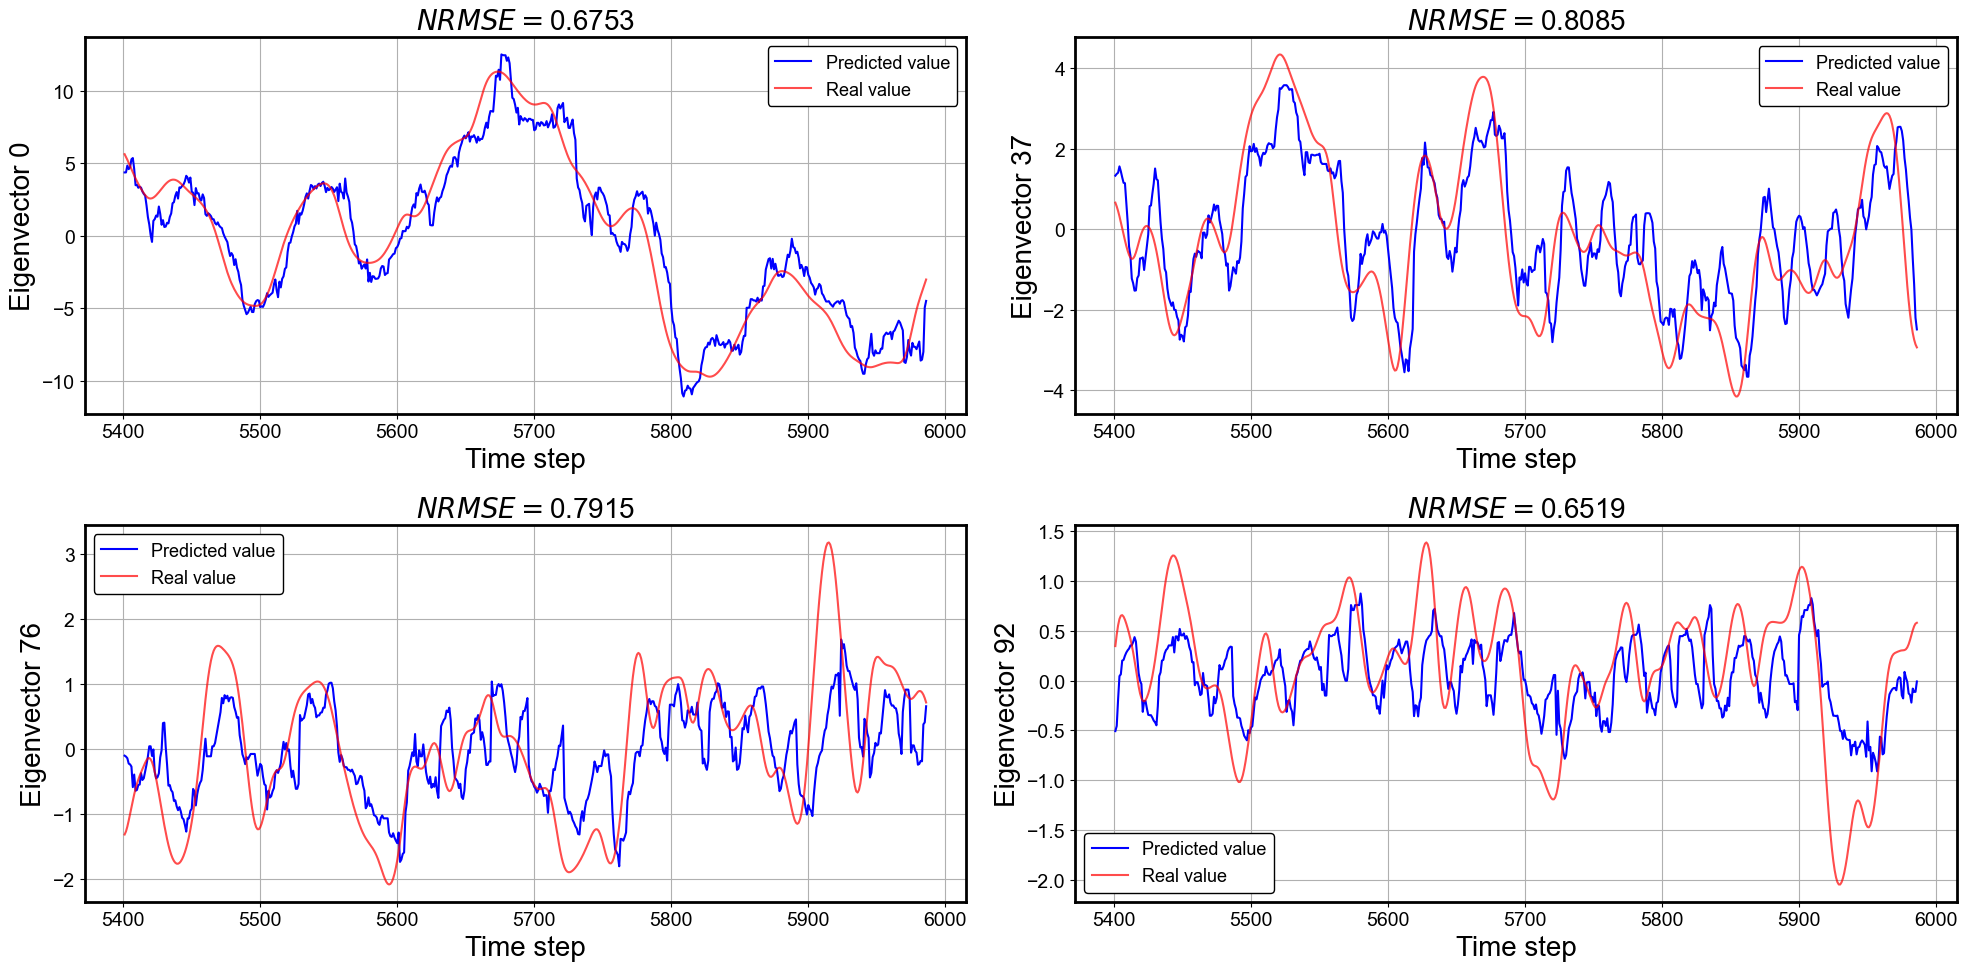

In [ ]:
# Plotting
fig, ax = plt.subplots(2, 2, figsize=(20, 10), tight_layout=True)
ax = ax.reshape((4,))
iax = 0

for i in tqdm([0,37,76,92]):

    # Import the dataset of a specific eigenvector to forecast
    path = 'dataframe_time_series/df_eigenvector_{}.csv'.format(i)
    dataframe = pd.read_csv(path, index_col=[0])
    dataframe_train = dataframe[:5400]
    dataframe_test = dataframe[5400:]

    l = load_model('trained_models/' + str(i), verbose=False)
    p = predict_model(l, data=dataframe_test)

    ax[iax].plot(p['Label'], color='blue', label='Predicted value')
    ax[iax].plot(p[dataframe.columns[-1]], color='red',
                 alpha=0.7, label='Real value')

    ax[iax].set_title('$NRMSE = $' + str(round(NRMSE[i],4)))
    ax[iax].set_xlabel('Time step')
    ax[iax].set_ylabel('Eigenvector ' + str(i))
    ax[iax].legend()
    iax += 1
